In [1]:
#import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.callbacks import *

In [2]:
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile

In [3]:
path = Path('/DATA/WAMRI/salk/uri/BPHO/')
path_processed = path/'processed'
model_dir = path/'models'
path_hr = path/'hires'
path_mr = path/'midres'
path_lr = path/'lores'
path_test = path/'test'

path_hr.mkdir(exist_ok=True)
path_mr.mkdir(exist_ok=True)
path_lr.mkdir(exist_ok=True)
path_test.mkdir(exist_ok=True)

In [4]:
def get_czi_shape_info(czi):
    shape = czi.shape
    axes = czi.axes
    axes_dict = {axis:idx for idx,axis in enumerate(czi.axes)}
    shape_dict = {axis:shape[axes_dict[axis]] for axis in czi.axes}
    return axes_dict, shape_dict


def build_index(axes, ix_select):
    idx = [ix_select.get(ax, 0) for ax in axes]
    return tuple(idx)

def process_czi(proc_fn):
    with czifile.CziFile(proc_fn) as proc_czf:
        proc_axes, proc_shape = get_czi_shape_info(proc_czf)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        x,y = proc_shape['X'], proc_shape['Y']
        data = proc_czf.asarray()
        for channel in range(channels):
            for depth in range(depths):
                idx = build_index(proc_axes, {'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
                img = data[idx]
                save_proc_fn = path_hr/f'{proc_fn.stem}_{channel:02d}_{depth:03d}.npy'
                np.save(save_proc_fn, img)
        

In [5]:
#proc_fns = list(path_processed.glob('*.czi'))
#for fn in progress_bar(proc_fns):
#    process_czi(fn)

In [6]:
def resize_one(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    data = np.load(fn)
    data = data.astype(float)
    data /= data.max()
    data *= 255
    data = data.astype(np.uint8)
    
    img = PIL.Image.fromarray(data, mode='L')
    targ_sz = resize_to(img,64,use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BICUBIC)
    img.save(str(dest).replace('.npy','.jpg'), quality=60)
    
def resize_two(fn,i):
    dest = path_mr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    data = np.load(fn)
    data = data.astype(float)
    data /= data.max()
    data *= 255
    data = data.astype(np.uint8)
    
    img = PIL.Image.fromarray(data, mode='L')
    targ_sz = resize_to(img,256,use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BICUBIC)
    img.save(str(dest).replace('.npy','.jpg'), quality=60)

In [7]:
# hr_fns = list(path_hr.glob('*.npy'))
# parallel(resize_two, hr_fns)

In [8]:
# hr_fns = list(path_hr.glob('*.npy'))
# parallel(resize_one, hr_fns)

In [9]:
class ProcImageList(ImageImageList):
    def open(self, fn):
        data = np.load(fn)
        x = torch.from_numpy(data[None,:,:].astype(np.float32))
        x.div_(x.max())
        return Image(x.repeat([3,1,1]))


In [10]:
def get_basename(x):
    return x.stem.split('_')[0]

base_names = list(set([get_basename(x) for x in list(path_lr.iterdir())]))
train_names, valid_names = random_split(0.15, base_names)
valid_names = list(valid_names[0])

def is_validation_basename(x):
    xbase = get_basename(x)
    return xbase in valid_names

src = (ImageItemList
       .from_folder(path_lr, label_cls=ProcImageList, extensions=".jpg", mode='L')
       .split_by_valid_func(is_validation_basename))

src_mr = (ImageItemList
       .from_folder(path_mr, label_cls=ProcImageList, extensions=".jpg", mode='L')
       .split_by_valid_func(is_validation_basename))

def get_data(src,bs,size, **kwargs):
    def lr_to_hr_fn(x):
        x_hr = path_hr/str(x.stem + ".npy")
        return x_hr
    
    tfms = get_transforms(max_zoom=2.)
    
    #y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    #tfms[0].append(jitter(magnitude=0.005))

    data = (src.label_from_func(lr_to_hr_fn)
            .transform(tfms, size=size, tfm_y=True)
            #.transform_y(y_tfms, size=size)
            .databunch(bs=bs,**kwargs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [11]:
arch = models.resnet34
bs,size = 16,4*64
data = get_data(src, bs, size, num_workers=0)
bs, size

(16, 256)

In [12]:
im1, im2 = data.train_ds[0]

(None, None)

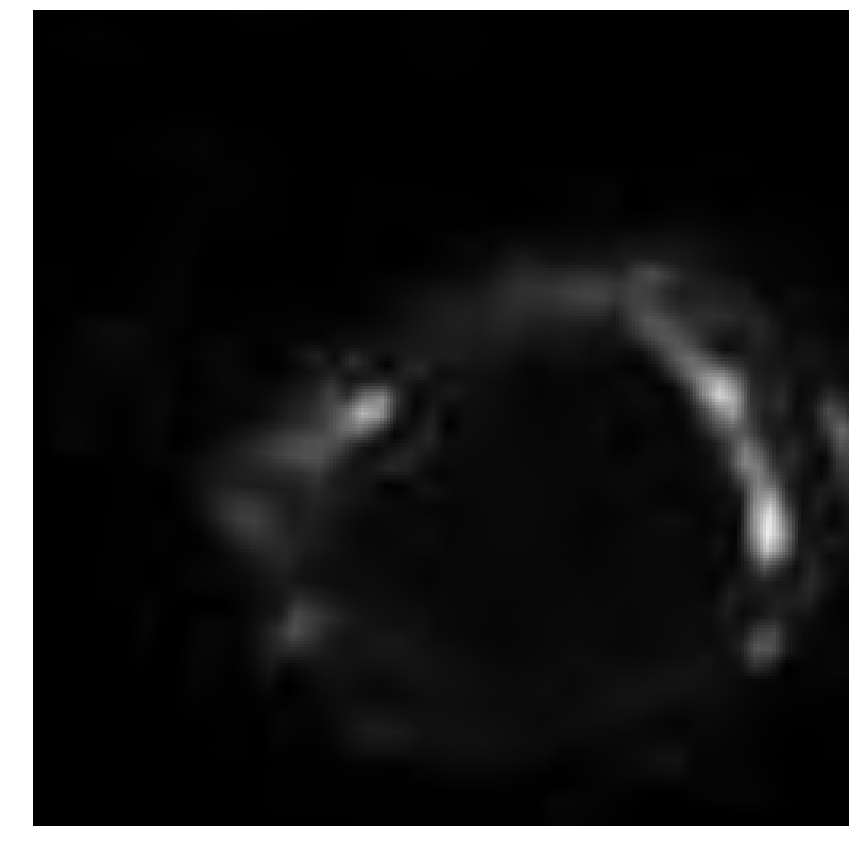

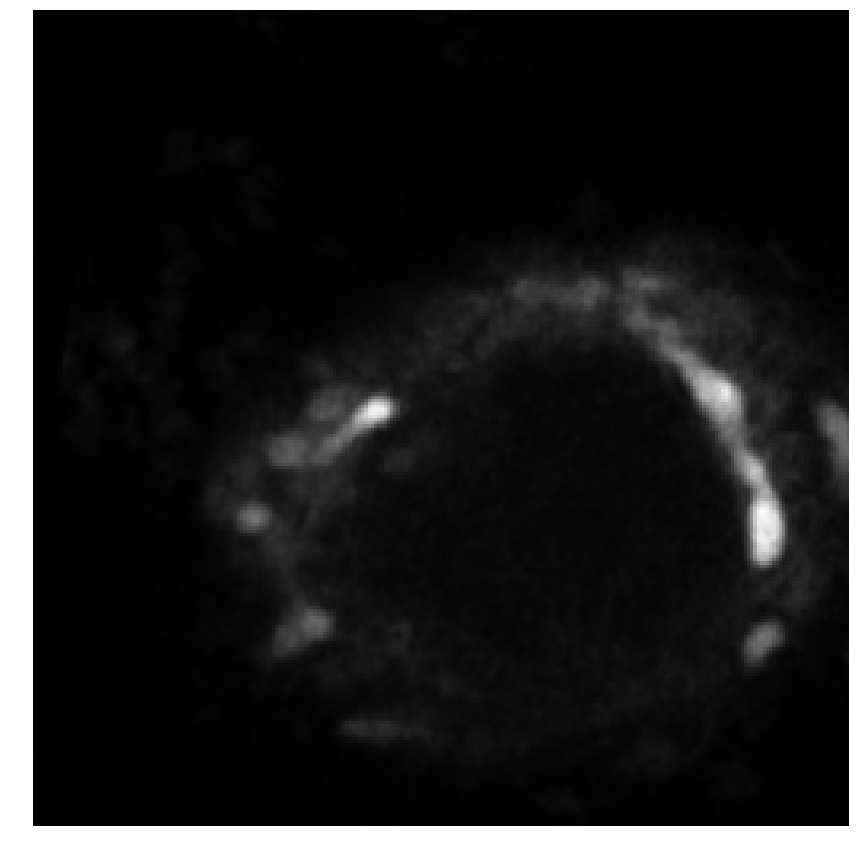

In [13]:
im1.show(figsize=(15,15)), im2.show(figsize=(15,15))

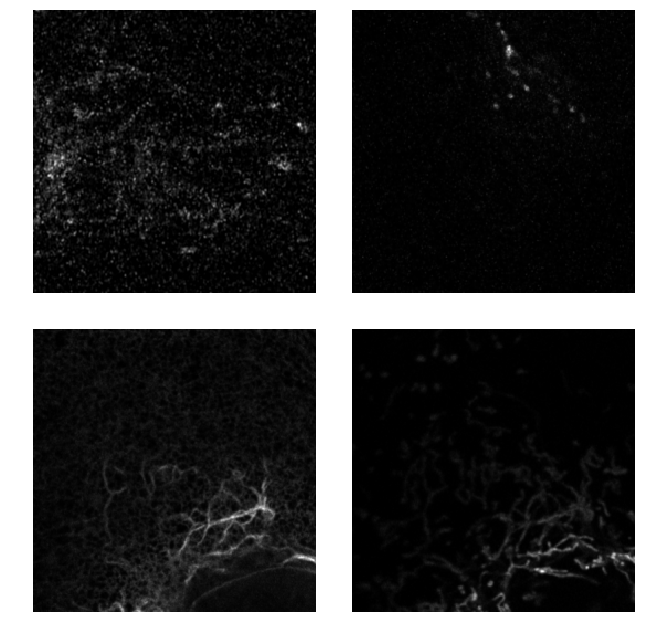

In [14]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [15]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [16]:
base_loss = F.l1_loss
#base_loss = F.mse_loss

In [17]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [18]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [19]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = (['pixel',] + 
                             [f'feat_{i}' for i in range(len(layer_ids))] + 
                             [f'gram_{i}' for i in range(len(layer_ids))])

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [F.mse_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [20]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [39]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight,
                     metrics=superres_metrics, model_dir=model_dir)
gc.collect()

0

In [22]:
# learn.lr_find(end_lr=10000)
# learn.recorder.plot()

In [23]:
lr = 1e-2
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, epochs=10):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)
    learn.recorder.plot_losses()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,4.978324,5.206311,3.131628,0.064479,-4.954497,3.131628,0.262023,0.270405,0.038284,0.787819,0.697928,0.018225
2,3.559520,2.660648,0.799964,0.195819,0.970439,0.799964,0.241862,0.254270,0.034838,0.674078,0.638364,0.017272
3,2.480083,1.951582,0.162677,0.278932,7.972828,0.162677,0.237526,0.250634,0.035709,0.632494,0.615612,0.016929
4,2.039963,1.888344,0.181710,0.313431,7.479903,0.181710,0.230001,0.251695,0.032645,0.605578,0.572115,0.014599
5,1.724082,1.449298,0.196969,0.284747,7.140752,0.196969,0.243661,0.213789,0.022396,0.392686,0.371253,0.008544
6,1.509343,1.480494,0.172385,0.307903,7.807731,0.172385,0.237395,0.223844,0.025510,0.388760,0.422751,0.009849
7,1.396742,1.301631,0.153735,0.254056,8.245452,0.153735,0.241723,0.200968,0.022441,0.331093,0.342983,0.008687
8,1.346088,1.335631,0.145490,0.267900,8.497745,0.145490,0.241803,0.213399,0.022446,0.326677,0.377330,0.008485
9,1.315777,1.239640,0.141969,0.277837,8.592714,0.141969,0.233347,0.202764,0.022076,0.314789,0.316314,0.008379
10,1.255159,1.165340,0.127336,0.283213,9.068565,0.127336,0.238421,0.200425,0.021756,0.275265,0.293807,0.008331


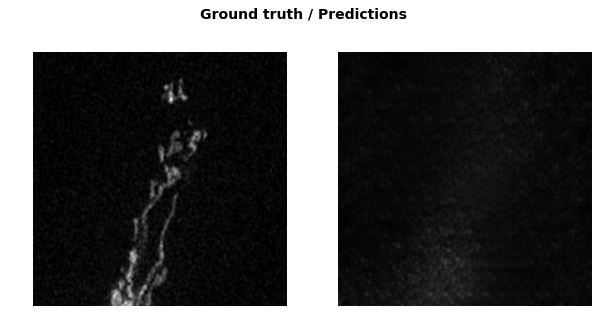

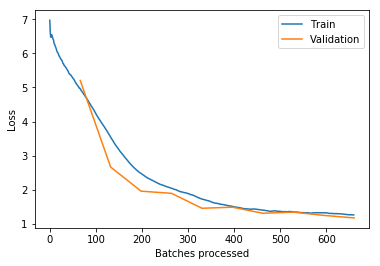

In [24]:
do_fit('1a', slice(lr*10))

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.207141,1.235980,0.127905,0.270494,9.049465,0.127905,0.240375,0.200987,0.021827,0.298561,0.337989,0.008336
2,1.206853,1.160811,0.127692,0.290133,9.065081,0.127692,0.235336,0.200043,0.021637,0.275114,0.292700,0.008289
3,1.201887,1.173669,0.127073,0.284666,9.083961,0.127073,0.238290,0.201390,0.021829,0.276251,0.300529,0.008307
4,1.193086,1.171172,0.126181,0.278127,9.113053,0.126181,0.237640,0.199186,0.021985,0.277207,0.300628,0.008346
5,1.192243,1.149049,0.124891,0.290275,9.160933,0.124891,0.237725,0.199410,0.021784,0.267586,0.289356,0.008297
6,1.197020,1.146097,0.124035,0.293615,9.193158,0.124035,0.237378,0.199789,0.021848,0.264465,0.290280,0.008302
7,1.181395,1.184654,0.123673,0.280175,9.203494,0.123673,0.239083,0.198810,0.021733,0.281918,0.311152,0.008286
8,1.177579,1.252506,0.123136,0.265420,9.216269,0.123136,0.238665,0.196859,0.022008,0.302776,0.360698,0.008364
9,1.187962,1.143426,0.122394,0.294684,9.250177,0.122394,0.239885,0.196800,0.021647,0.262218,0.292203,0.008278
10,1.172760,1.117519,0.120761,0.296583,9.311439,0.120761,0.237946,0.198081,0.021816,0.250501,0.280134,0.008280


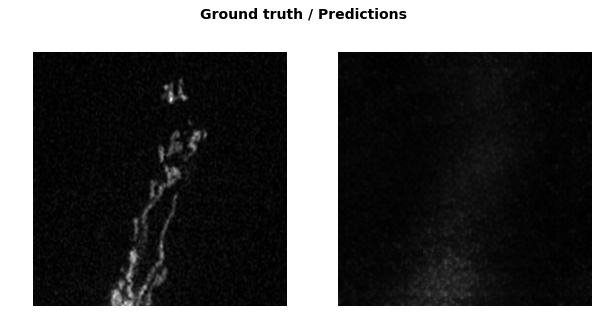

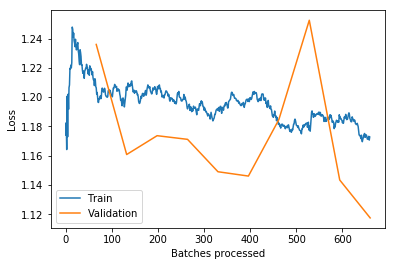

In [25]:
do_fit('1a', slice(lr))

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.165328,1.165283,0.121633,0.289457,9.279462,0.121633,0.240049,0.197034,0.021735,0.270838,0.305715,0.008278
2,1.158664,1.158931,0.121088,0.286802,9.296707,0.121088,0.240912,0.196292,0.021631,0.266554,0.304183,0.008271
3,1.163960,1.134768,0.120791,0.285417,9.304544,0.120791,0.239376,0.194321,0.021710,0.260981,0.289303,0.008286
4,1.159742,1.123940,0.119801,0.294888,9.340558,0.119801,0.240519,0.197400,0.021852,0.251705,0.284377,0.008287
5,1.164540,1.182507,0.120073,0.279481,9.329580,0.120073,0.243534,0.198508,0.021927,0.267832,0.322340,0.008293
6,1.159859,1.107380,0.119211,0.300272,9.365134,0.119211,0.238395,0.196960,0.021712,0.247809,0.275024,0.008269
7,1.156445,1.114222,0.121035,0.294738,9.299155,0.121035,0.241487,0.198368,0.021724,0.244697,0.278669,0.008243
8,1.156582,1.156254,0.117585,0.294240,9.420371,0.117585,0.239975,0.198231,0.021916,0.265590,0.304649,0.008308
9,1.161091,1.121151,0.122400,0.297945,9.243791,0.122400,0.240252,0.200502,0.021860,0.246246,0.281642,0.008250
10,1.143506,1.171836,0.118303,0.286414,9.398554,0.118303,0.241929,0.199295,0.022045,0.263859,0.318088,0.008318


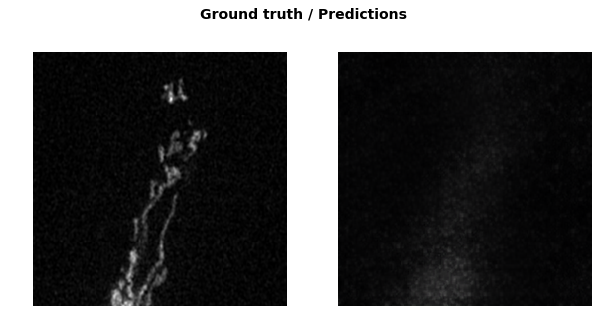

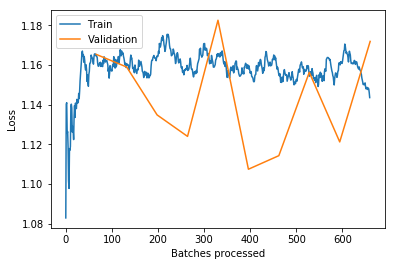

In [27]:
do_fit('1b', slice(lr/1000,lr/10))

In [28]:
# bs, size
# learn = learn.load('1b')

In [29]:
data = get_data(src, bs//4,size*2)
learn.data = data
learn.freeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.089567,0.933041,0.096832,0.345373,10.558811,0.096832,0.235353,0.183292,0.018958,0.208400,0.183043,0.007163
2,1.040290,0.917321,0.096647,0.346354,10.572510,0.096647,0.234415,0.181313,0.018849,0.202622,0.176344,0.007130
3,1.033157,0.930526,0.088676,0.371509,10.925918,0.088676,0.233365,0.181615,0.018534,0.217443,0.183806,0.007086
4,1.046219,0.900292,0.088171,0.358432,10.955096,0.088171,0.231135,0.179766,0.018304,0.202580,0.173312,0.007024
5,1.027113,0.917006,0.094748,0.363223,10.646404,0.094748,0.229579,0.176318,0.017967,0.214216,0.177140,0.007037
6,1.023842,0.957774,0.089487,0.332559,10.877594,0.089487,0.233629,0.176041,0.018082,0.221199,0.212293,0.007042
7,1.028655,0.903075,0.086469,0.360607,11.030917,0.086469,0.231728,0.175907,0.018119,0.202708,0.181054,0.007089
8,1.016211,0.899819,0.085710,0.358185,11.076156,0.085710,0.229336,0.175167,0.017994,0.204806,0.179806,0.007001
9,1.008333,0.882076,0.081854,0.382023,11.281953,0.081854,0.226430,0.177128,0.018557,0.203152,0.168027,0.006928
10,0.954954,0.862476,0.082356,0.370979,11.242783,0.082356,0.227672,0.175379,0.018287,0.188136,0.163734,0.006912


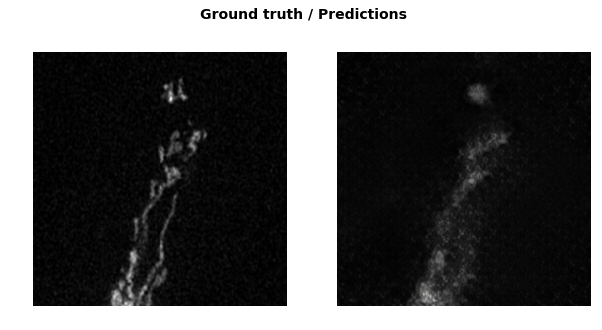

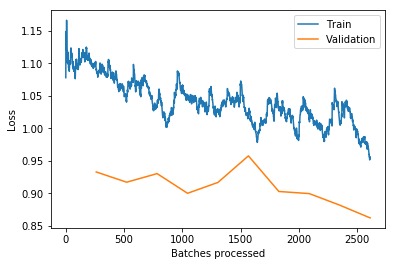

In [30]:
do_fit('2a')

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.977347,0.932337,0.084050,0.349608,11.139520,0.084050,0.230088,0.175277,0.018061,0.215110,0.202810,0.006941
2,0.985106,0.898258,0.081862,0.360762,11.268049,0.081862,0.226449,0.174102,0.017995,0.202784,0.188120,0.006947
3,0.967998,0.950690,0.097603,0.320775,10.297664,0.097603,0.235834,0.182332,0.019126,0.207767,0.200935,0.007094
4,0.998972,0.927761,0.080555,0.358941,11.322615,0.080555,0.228495,0.177265,0.018432,0.213153,0.202875,0.006986
5,0.986338,0.880094,0.076202,0.367114,11.569464,0.076202,0.228031,0.175554,0.018303,0.195055,0.179993,0.006956
6,0.965301,0.892218,0.076037,0.361975,11.563622,0.076037,0.227147,0.175864,0.018280,0.207635,0.180349,0.006906
7,0.975738,0.891850,0.076248,0.377203,11.587728,0.076248,0.224723,0.174179,0.018118,0.210530,0.181146,0.006905
8,0.950276,0.896538,0.075633,0.366181,11.610415,0.075633,0.226839,0.174220,0.018280,0.206944,0.187703,0.006920
9,0.946073,0.839817,0.077386,0.381174,11.500581,0.077386,0.226045,0.176900,0.018912,0.178605,0.155032,0.006938
10,0.949444,0.838017,0.074346,0.380232,11.682940,0.074346,0.224601,0.174369,0.018350,0.182819,0.156646,0.006887


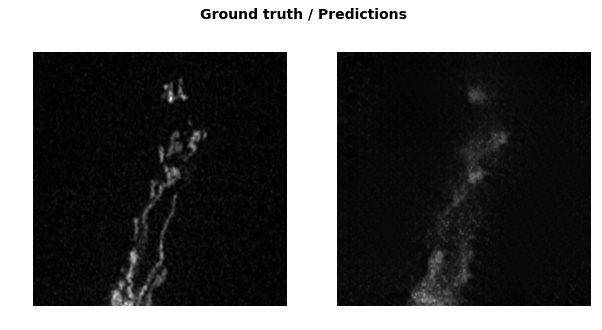

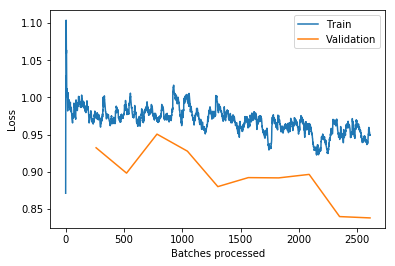

In [32]:
do_fit('2b', slice(lr/1000,lr/10), pct_start=0.3)

In [ ]:
data = get_data(src_mr, bs//8, size*3)
learn.data = data
do_fit('3', slice(lr/1000,lr/10), pct_start=0.3)

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.946863,0.774139,0.055324,0.458366,13.016816,0.055324,0.229118,0.173192,0.017281,0.172487,0.120939,0.005797
2,0.959605,0.779999,0.053342,0.449640,13.206060,0.053342,0.228608,0.172833,0.017475,0.169753,0.132235,0.005754
3,0.947521,0.846820,0.052986,0.467623,13.167109,0.052986,0.232074,0.176485,0.017469,0.215687,0.146518,0.005602
4,0.909893,0.787170,0.048692,0.479163,13.683454,0.048692,0.226782,0.174517,0.017894,0.187309,0.126382,0.005594
5,0.904982,0.808458,0.053180,0.457630,13.208853,0.053180,0.229846,0.172185,0.016914,0.184189,0.146354,0.005790
6,0.872823,0.876975,0.073264,0.404789,11.680854,0.073264,0.233250,0.177653,0.018194,0.205021,0.163842,0.005752
7,0.864038,0.833156,0.059579,0.429326,12.542454,0.059579,0.231543,0.174622,0.017377,0.189331,0.154924,0.005780
8,0.852452,0.837191,0.062656,0.437087,12.315488,0.062656,0.231999,0.175879,0.017629,0.191157,0.152186,0.005685


In [ ]:
data = get_data(src_mr, bs//8, size*3)
learn.data = data
learn.unfreeze()
do_fit('4', slice(lr/1000,lr/100), pct_start=0.3, epochs=30)

In [ ]:
#learn.save('fred2')
learn = learn.to_fp16().load('2b')
bs,size = 1,2024
data = get_data(src_mr, bs, size)
learn.data = data


In [ ]:
learn.data = data
tst_imgs  = list(Path('/DATA/WAMRI/salk/uri/Image_restoration_data/newimg/').iterdir())

In [ ]:
def my_pred(self, item:ItemBase, **kwargs):
    self.callbacks.append(RecordOnCPU())
    batch = self.data.one_item(item)
    batch = to_half(batch)
    res = self.pred_batch(batch=batch)
    pred = res[0]
    x = self.callbacks[-1].input
    x = x.float()
    pred = pred.float()
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False): pred = self.data.denorm(pred)
    self.callbacks = self.callbacks[:-1]
    ds = self.data.single_ds
    pred = ds.y.analyze_pred(pred, **kwargs)
    out = ds.y.reconstruct(pred, ds.x.reconstruct(x[0])) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
    return out, pred, res[0]

In [ ]:
fn = tst_imgs[1]
img = open_grayscale(fn)

a,b,c = my_pred(learn, img)
img2 = PIL.Image.open(fn)

In [ ]:
agray = Image(a.data[0:1,:,:])
agray.shape

In [ ]:
agray

In [ ]:
img

#ssim.ssim(agray.data[None], img.data[None])

In [ ]:
lrhr_path = Path('/DATA/WAMRI/salk/uri/Image_restoration_data/')
train_lr = lrhr_path/'train_LR'
train_hr = lrhr_path/'train_HR'

def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

def match_hr_fn(x):
    return hr_names_by_id[pull_id(x.name)]

lr_names_full = list(train_lr.glob('*.tif'))
lr_names_full.sort()
hr_names_by_id = {pull_id(hrfn.name):hrfn for hrfn in train_hr.glob('*.tif')}

In [ ]:
lr_fn = lr_names_full[0]
hr_fn = hr_names_by_id[pull_id(str(lr_fn))]

In [ ]:
lr_img = PIL.Image.open(lr_fn)
hr_img = PIL.Image.open(hr_fn)
print(hr_img.size)
lr_img = lr_img.crop((3,3,509,509)).resize((2024,2024), resample=PIL.Image.BICUBIC)
hr_img = hr_img.resize((2024,2024), resample=PIL.Image.BICUBIC)


x = pil2tensor(lr_img,np.float32)
xmax = x.max()
x.div_(xmax)
x = Image(x)

y = pil2tensor(hr_img,np.float32)
ymax = y.max()
y.div_(ymax)
y = Image(y)

pred_y,_,_ = my_pred(learn,x)

In [ ]:
inp, targ = pred_y.data[None], y.data[None]
F.mse_loss(inp, targ), ssim.ssim(inp, targ), psnr(inp, targ)

In [ ]:
inp, targ = x.data[None], y.data[None]
F.mse_loss(inp, targ), ssim.ssim(inp, targ), psnr(inp, targ)

In [ ]:
pred_y

In [ ]:
x

In [ ]:
y

In [ ]:
import torch.nn.parallel as parallel

In [ ]:
class TestNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn = nn.BatchNorm2d(12)
    def forward(self, x):
        return self.bn(x)
    
tn = TestNet().cuda()

bn0, bn1, bn2 = parallel.replicate(tn, [0,1,2])

In [ ]:
bn2.bn.running_mean.get_device()